<a href="https://colab.research.google.com/github/dipasreepoddar/fastbook/blob/master/exercises/bear_classifier_multi_label.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [2]:
#hide
from fastbook import *
from fastai.vision.widgets import *

In [4]:
key = os.environ.get('AZURE_SEARCH_KEY', 'XXX')

In [5]:
bear_types = 'grizzly','black','teddy'
path = Path('bears')

In [6]:
if not path.exists():
    path.mkdir()
    for o in bear_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o} bear')
        download_images(dest, urls=results.attrgot('contentUrl'))

In [6]:
fns = get_image_files(path)
fns

(#392) [Path('bears/black/00000010.jpg'),Path('bears/black/00000119.jpg'),Path('bears/black/00000064.jpg'),Path('bears/black/00000062.jpg'),Path('bears/black/00000135.jpg'),Path('bears/black/00000072.jpg'),Path('bears/black/00000137.jpg'),Path('bears/black/00000094.jpg'),Path('bears/black/00000069.jpg'),Path('bears/black/00000003.jpg')...]

# Clean the dataset using single category bear classifier

In [7]:
failed = verify_images(fns)
failed

(#0) []

In [8]:
failed.map(Path.unlink);

In [9]:
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())

In [10]:
dls = bears.dataloaders(path)

In [11]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.158117,0.249946,0.128205,00:16


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


epoch,train_loss,valid_loss,error_rate,time
0,0.155670,0.065319,0.012821,00:16
1,0.142289,0.054041,0.025641,00:16
2,0.100273,0.079520,0.012821,00:15
3,0.082242,0.084029,0.012821,00:15


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


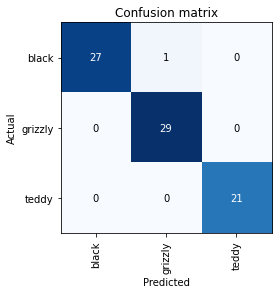

In [12]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

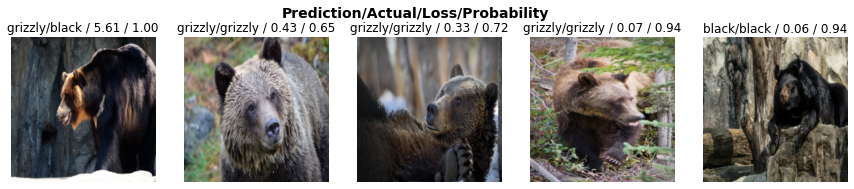

In [13]:
interp.plot_top_losses(5, nrows=1)

In [14]:
cleaner = ImageClassifierCleaner(learn)
cleaner

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [15]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

# Multi Label Bear Classifier

In [7]:
def parent_label_multi(o): return [Path(o).parent.name]

In [25]:
bears_multicat = DataBlock(
    blocks=(ImageBlock, MultiCategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label_multi,
    item_tfms=RandomResizedCrop(224, min_scale=0.5))

In [26]:
dls = bears_multicat.dataloaders(path)

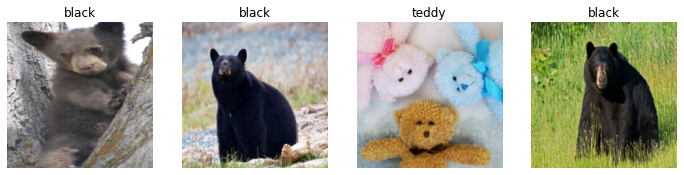

In [27]:
dls.valid.show_batch(max_n=4, nrows=1)

In [28]:
learn = cnn_learner(dls, resnet18)

In [29]:
x,y = to_cpu(dls.train.one_batch())
activs = learn.model(x)
activs.shape

torch.Size([64, 3])

In [30]:
def binary_cross_entropy(inputs, targets):
    inputs = inputs.sigmoid()
    return -torch.where(targets==1, 1-inputs, inputs).log().mean()

In [31]:
loss_func = nn.BCEWithLogitsLoss()
loss = loss_func(activs, y)
loss

TensorMultiCategory(1.2640, grad_fn=<AliasBackward>)

In [32]:
learn = cnn_learner(dls, resnet50, metrics=partial(accuracy_multi, thresh=0.6))
learn.fine_tune(3, base_lr=3e-3, freeze_epochs=4)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.628598,0.478310,0.769231,00:17
1,0.380332,0.117628,0.965812,00:17
2,0.270362,0.111347,0.970086,00:16
3,0.201516,0.094448,0.978633,00:17


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.025844,0.178799,0.961538,00:17
1,0.022229,0.131406,0.987179,00:17
2,0.021376,0.102853,0.991453,00:17


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [17]:
learn.metrics = partial(accuracy_multi, thresh=0.5)
learn.validate()

(#2) [0.20140336453914642,0.9615384340286255]

In [33]:
preds,targs = learn.get_preds()

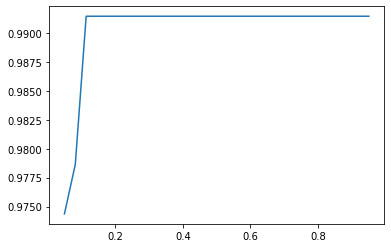

In [34]:
xs = torch.linspace(0.05,0.95,29)
accs = [accuracy_multi(preds, targs, thresh=i, sigmoid=False) for i in xs]
plt.plot(xs,accs);

In [42]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

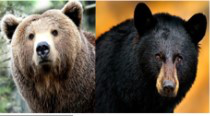

In [66]:
img = PILImage.create(btn_upload.data[-1])
img

In [67]:
pred,pred_idx,probs = learn.predict(img)
pred,pred_idx,probs

((#2) ['black','grizzly'],
 tensor([ True,  True, False]),
 tensor([8.0019e-01, 9.5474e-01, 8.1476e-04]))